In [7]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [2]:
RECOGNIZED_DOG_LABELS = {
    'Labrador_retriever', 'German_shepherd', 'golden_retriever', 'beagle', 'bulldog',
    'poodle', 'Rottweiler', 'boxer', 'pug', 'corgi', 'Siberian_husky', 'Chihuahua',
    'Shih-Tzu', 'Yorkshire_terrier', 'Pomeranian', 'collie', 'Doberman',
    'Shetland_sheepdog', 'toy_terrier', 'cocker_spaniel', 'Irish_setter', 'basset',
    'bloodhound', 'bull_mastiff', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog',
    'dog', 'puppy', 'Pembroke', 'Pembroke_Welsh_corgi',
}

RECOGNIZED_CAT_LABELS = {
    'tabby', 'tiger_cat', 'Persian_cat', 'Siamese_cat', 'Egyptian_cat', 'lynx',
    'cat', 'kitten', 'Egyptian_mau', 'Turkish_van'
}

DOG_COLOR = (0, 0, 255)  # đỏ
CAT_COLOR = (0, 255, 0)  # xanh lá

In [3]:
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0] - windowSize[1] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[0] + 1, stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [4]:
def is_recognized_label(label):
    return label in RECOGNIZED_DOG_LABELS or label in RECOGNIZED_CAT_LABELS

def get_color_by_label(label):
    if label in RECOGNIZED_DOG_LABELS:
        return DOG_COLOR
    elif label in RECOGNIZED_CAT_LABELS:
        return CAT_COLOR
    else:
        return (255, 255, 255)  # trắng

def apply_nms(boxes, confidences, conf_threshold, iou_threshold):
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, iou_threshold)
    return indices

In [9]:
def detect_dog_cat_in_image(
    image_path,
    input_size_mobilenet=(224, 224),
    roi_base_size=(80, 80),
    window_step_size=16,
    min_confidence=0.4,
    nms_iou_threshold=0.3,
    label_filter=['dog', 'cat'],   # Mặc định nhận cả dog và cat
):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Không tìm thấy file ảnh: {image_path}")
    orig = image.copy()

    model = MobileNetV2(weights='imagenet')

    # Chuyển label_filter về dạng set cho lookup nhanh
    if isinstance(label_filter, str):
        label_filter = [label_filter]
    label_filter = set([l.lower() for l in label_filter])

    boxes = []
    confidences = []
    labels = []

    for (x, y, window) in sliding_window(image, window_step_size, roi_base_size):
        if window.shape[0] != roi_base_size[1] or window.shape[1] != roi_base_size[0]:
            continue

        roi = cv2.resize(window, input_size_mobilenet)
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = preprocess_input(roi)
        roi = np.expand_dims(roi, axis=0)

        preds = model.predict(roi)
        decoded = decode_predictions(preds, top=1)[0][0]
        label, conf = decoded[1], decoded[2]

        label_lower = label.lower()

        # Kiểm tra xem label có trong filter và thuộc dog hoặc cat
        is_dog_label = label in RECOGNIZED_DOG_LABELS
        is_cat_label = label in RECOGNIZED_CAT_LABELS
        if conf > min_confidence:
            if ('dog' in label_filter and is_dog_label) or ('cat' in label_filter and is_cat_label):
                boxes.append([x, y, roi_base_size[0], roi_base_size[1]])
                confidences.append(float(conf))
                labels.append(label)

    indices = apply_nms(boxes, confidences, min_confidence, nms_iou_threshold)

    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = labels[i]
        conf = confidences[i]
        color = get_color_by_label(label)
    
        # Chuyển label giống thành nhãn chung
        if label in RECOGNIZED_DOG_LABELS:
            display_label = "dog"
        elif label in RECOGNIZED_CAT_LABELS:
            display_label = "cat"
        else:
            display_label = label  # hoặc bạn có thể để "" để không hiển thị
    
        cv2.rectangle(orig, (x, y), (x + w, y + h), color, 2)
        cv2.putText(orig, f"{display_label}: {conf:.2f}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    # Convert BGR (OpenCV format) to RGB (matplotlib format)
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Display using matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(orig_rgb)
    plt.axis('off')
    plt.title("Dog & Cat Detection")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 

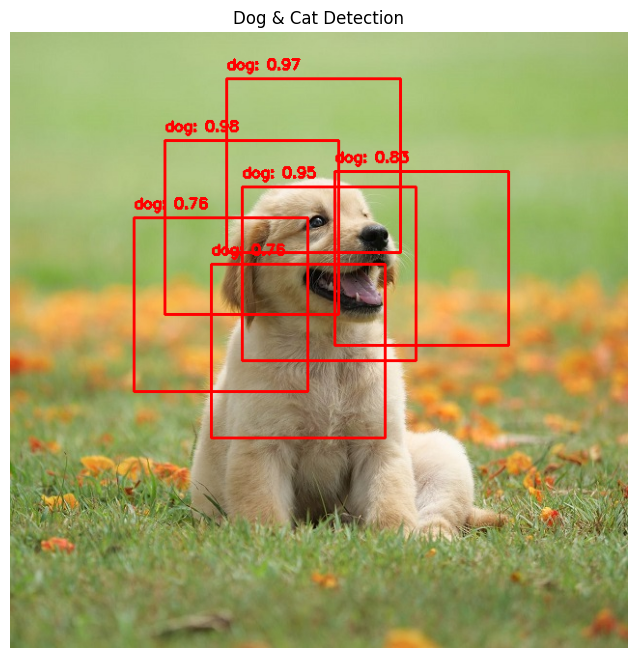

In [10]:
detect_dog_cat_in_image(
    './images/dog01.jpg',
    roi_base_size=(180, 180),
    window_step_size=16,
    min_confidence=0.6,
    nms_iou_threshold=0.3,
    label_filter=['dog']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━

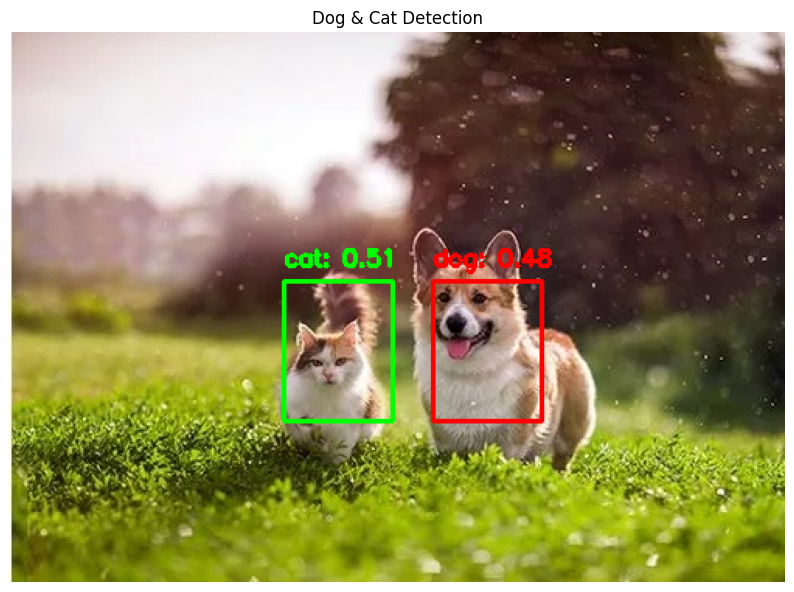

: 

In [11]:
detect_dog_cat_in_image(
    './images/dogcat.jpg',
    roi_base_size=(70, 90),
    window_step_size=16,
    min_confidence=0.4,
    nms_iou_threshold=0.3,
    label_filter=['dog', 'cat']
)